In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.io               import fits
from astropy.visualization    import ZScaleInterval
from astropy.wcs              import WCS
from matplotlib.ticker        import FormatStrFormatter, MultipleLocator
from scipy.interpolate        import interp1d
from global_functions_library import plot_image, make_mask_and_compute_background_statistics, do_aperture_photometric_by_peak_brightness, do_aperture_photometric_by_radius

## V Band Analysis

In [2]:
fits_file_path = "/home/koarakawaii/Lecture_Code/Advanced_Astronomical_Observation/Term_Project/image_processing/FITS_SDSS_Elliptical_Galaxy/SDSS2258+0017_corrected/V/plate_solving/SDSS2258+0017_V_5min_stacked_plate_solved.fit"
with fits.open("%s"%(fits_file_path)) as hdul:
    imag_header = hdul[0].header 
    imag_data   = hdul[0].data

object_name             = "SDSS2258+0017"
wcs                     = WCS(imag_header)
object_center_pos_pixel = wcs.all_world2pix([[344.49737, 0.29520]], 0)[0]
v_min, v_max            = ZScaleInterval().get_limits(values=imag_data)
m_inst_V_band_filename_max  = "./SDSS_INSTRUMENTAL_MAGNITUDE/V_band_maximum.txt"
m_inst_V_band_filename_sat  = "./SDSS_INSTRUMENTAL_MAGNITUDE/V_band_saturated.txt"

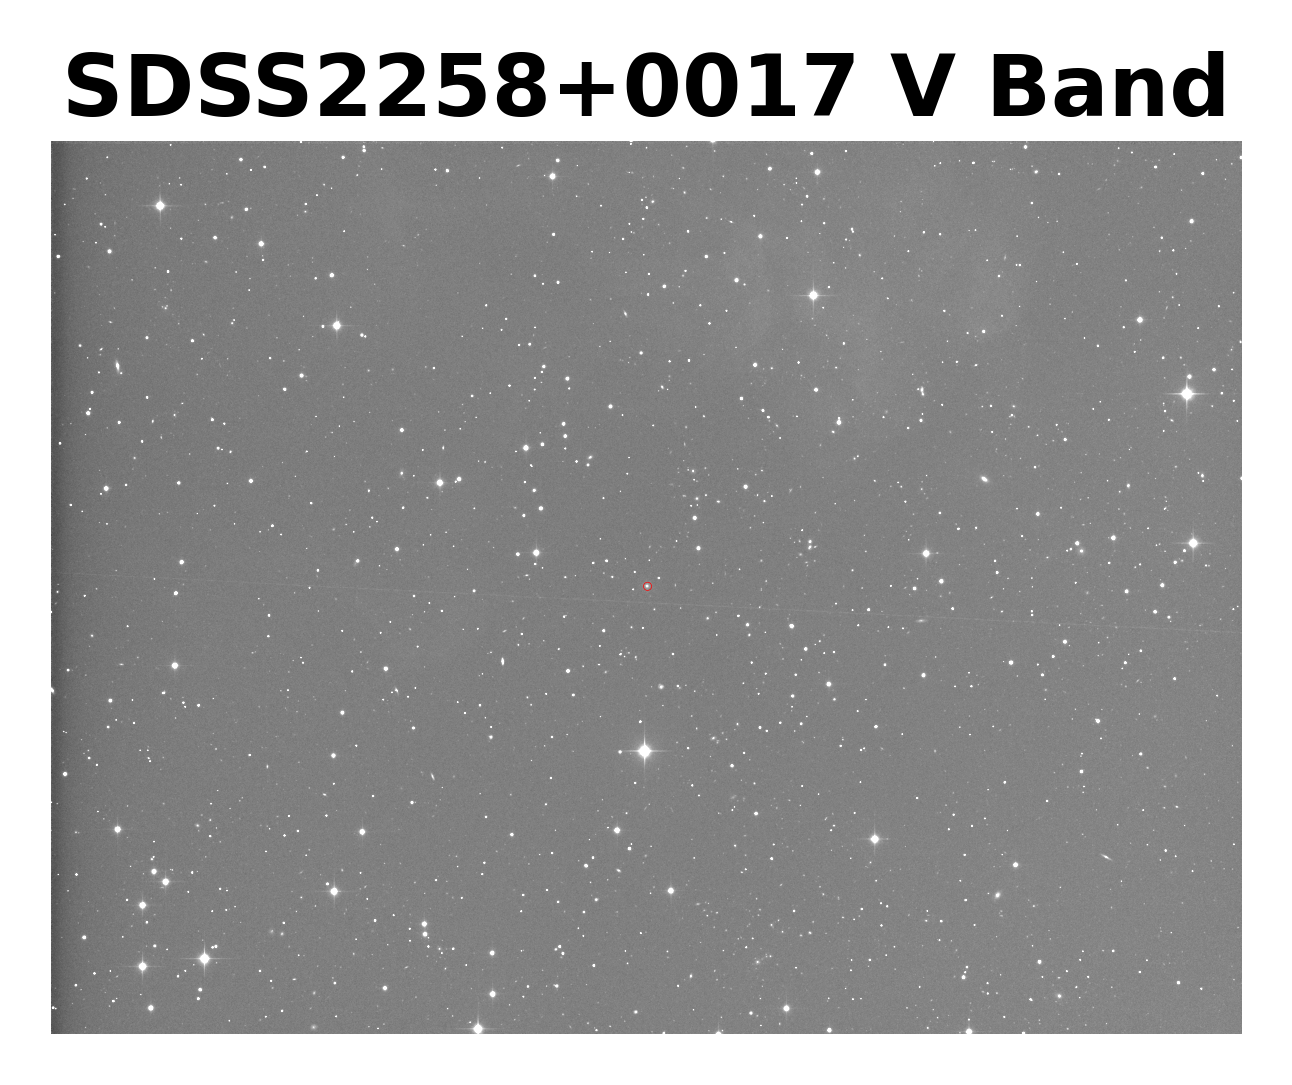

In [3]:
save_file_path = "./photo_gallery"
save_fig_name  = "%s_%s_band_reduced_image_target_highlighted"%(object_name,imag_header["FILTER"])
dpi            = 512
fig            = plt.figure(figsize=(3,3), dpi=dpi)
ax             = plt.subplot(111)
plot_image(ax=ax, image_array=imag_data, v_min=v_min, v_max=v_max, cmap="gray", norm_type="log", title="SDSS2258+0017 %s Band"%imag_header["FILTER"])
circle         = plt.Circle((object_center_pos_pixel[0], object_center_pos_pixel[1]), 20.0, lw=0.1, color='r', fill=False)
ax.add_patch(circle)
ax.set_title("SDSS2258+0017 %s Band"%imag_header["FILTER"], fontsize=12., weight="bold", y=0.98)
plt.savefig("%s/%s.png"%(save_file_path,save_fig_name), bbox_inches='tight', dpi=dpi, pad_inches=0.02, facecolor='white', transparent=True)

In [26]:
how_many_sigma                            = 3.0
max_iter_criteria                         = 10
crop_size                                 = 210
object_circle_radius                      = 25                 # unit in pixels, manually obtained by ds9
background_circle_radius                  = 7.0*object_circle_radius

imag_data_crop, mask_clipped, object_mask,\
background_mask, object_crop_center_pos_pixel,\
background_pixel_count, background_brightness_mean,\
background_brightness_mean_error, background_brightness_std\
                                          = make_mask_and_compute_background_statistics(imag_array= imag_data, object_center_pos_pixel=object_center_pos_pixel, crop_size=crop_size, object_circle_radius=object_circle_radius, background_circle_radius=background_circle_radius, how_many_sigma=how_many_sigma, max_iter_criteria=max_iter_criteria)

print("%s %s band background noise measurement:"%(object_name, imag_header["FILTER"]))
print("\tPixel counts for the background region is %d ."%(background_pixel_count))
print("\tMean of the background pixel brightness is %.4e ± %.4e %s for the crop image."%(background_brightness_mean, background_brightness_mean_error, "UNIT"))
print("\tStandard deviation of the background pixel brightness is %.4e %s for the crop image."%(background_brightness_std, "UNIT"))

SDSS2258+0017 V band background noise measurement:
	Pixel counts for the background region is 93561 .
	Mean of the background pixel brightness is 2.1192e-05 ± 1.3821e-09 UNIT for the crop image.
	Standard deviation of the background pixel brightness is 4.2275e-07 UNIT for the crop image.


Text(0.5, 1.07, 'Comparison between Original and Clipped Images')

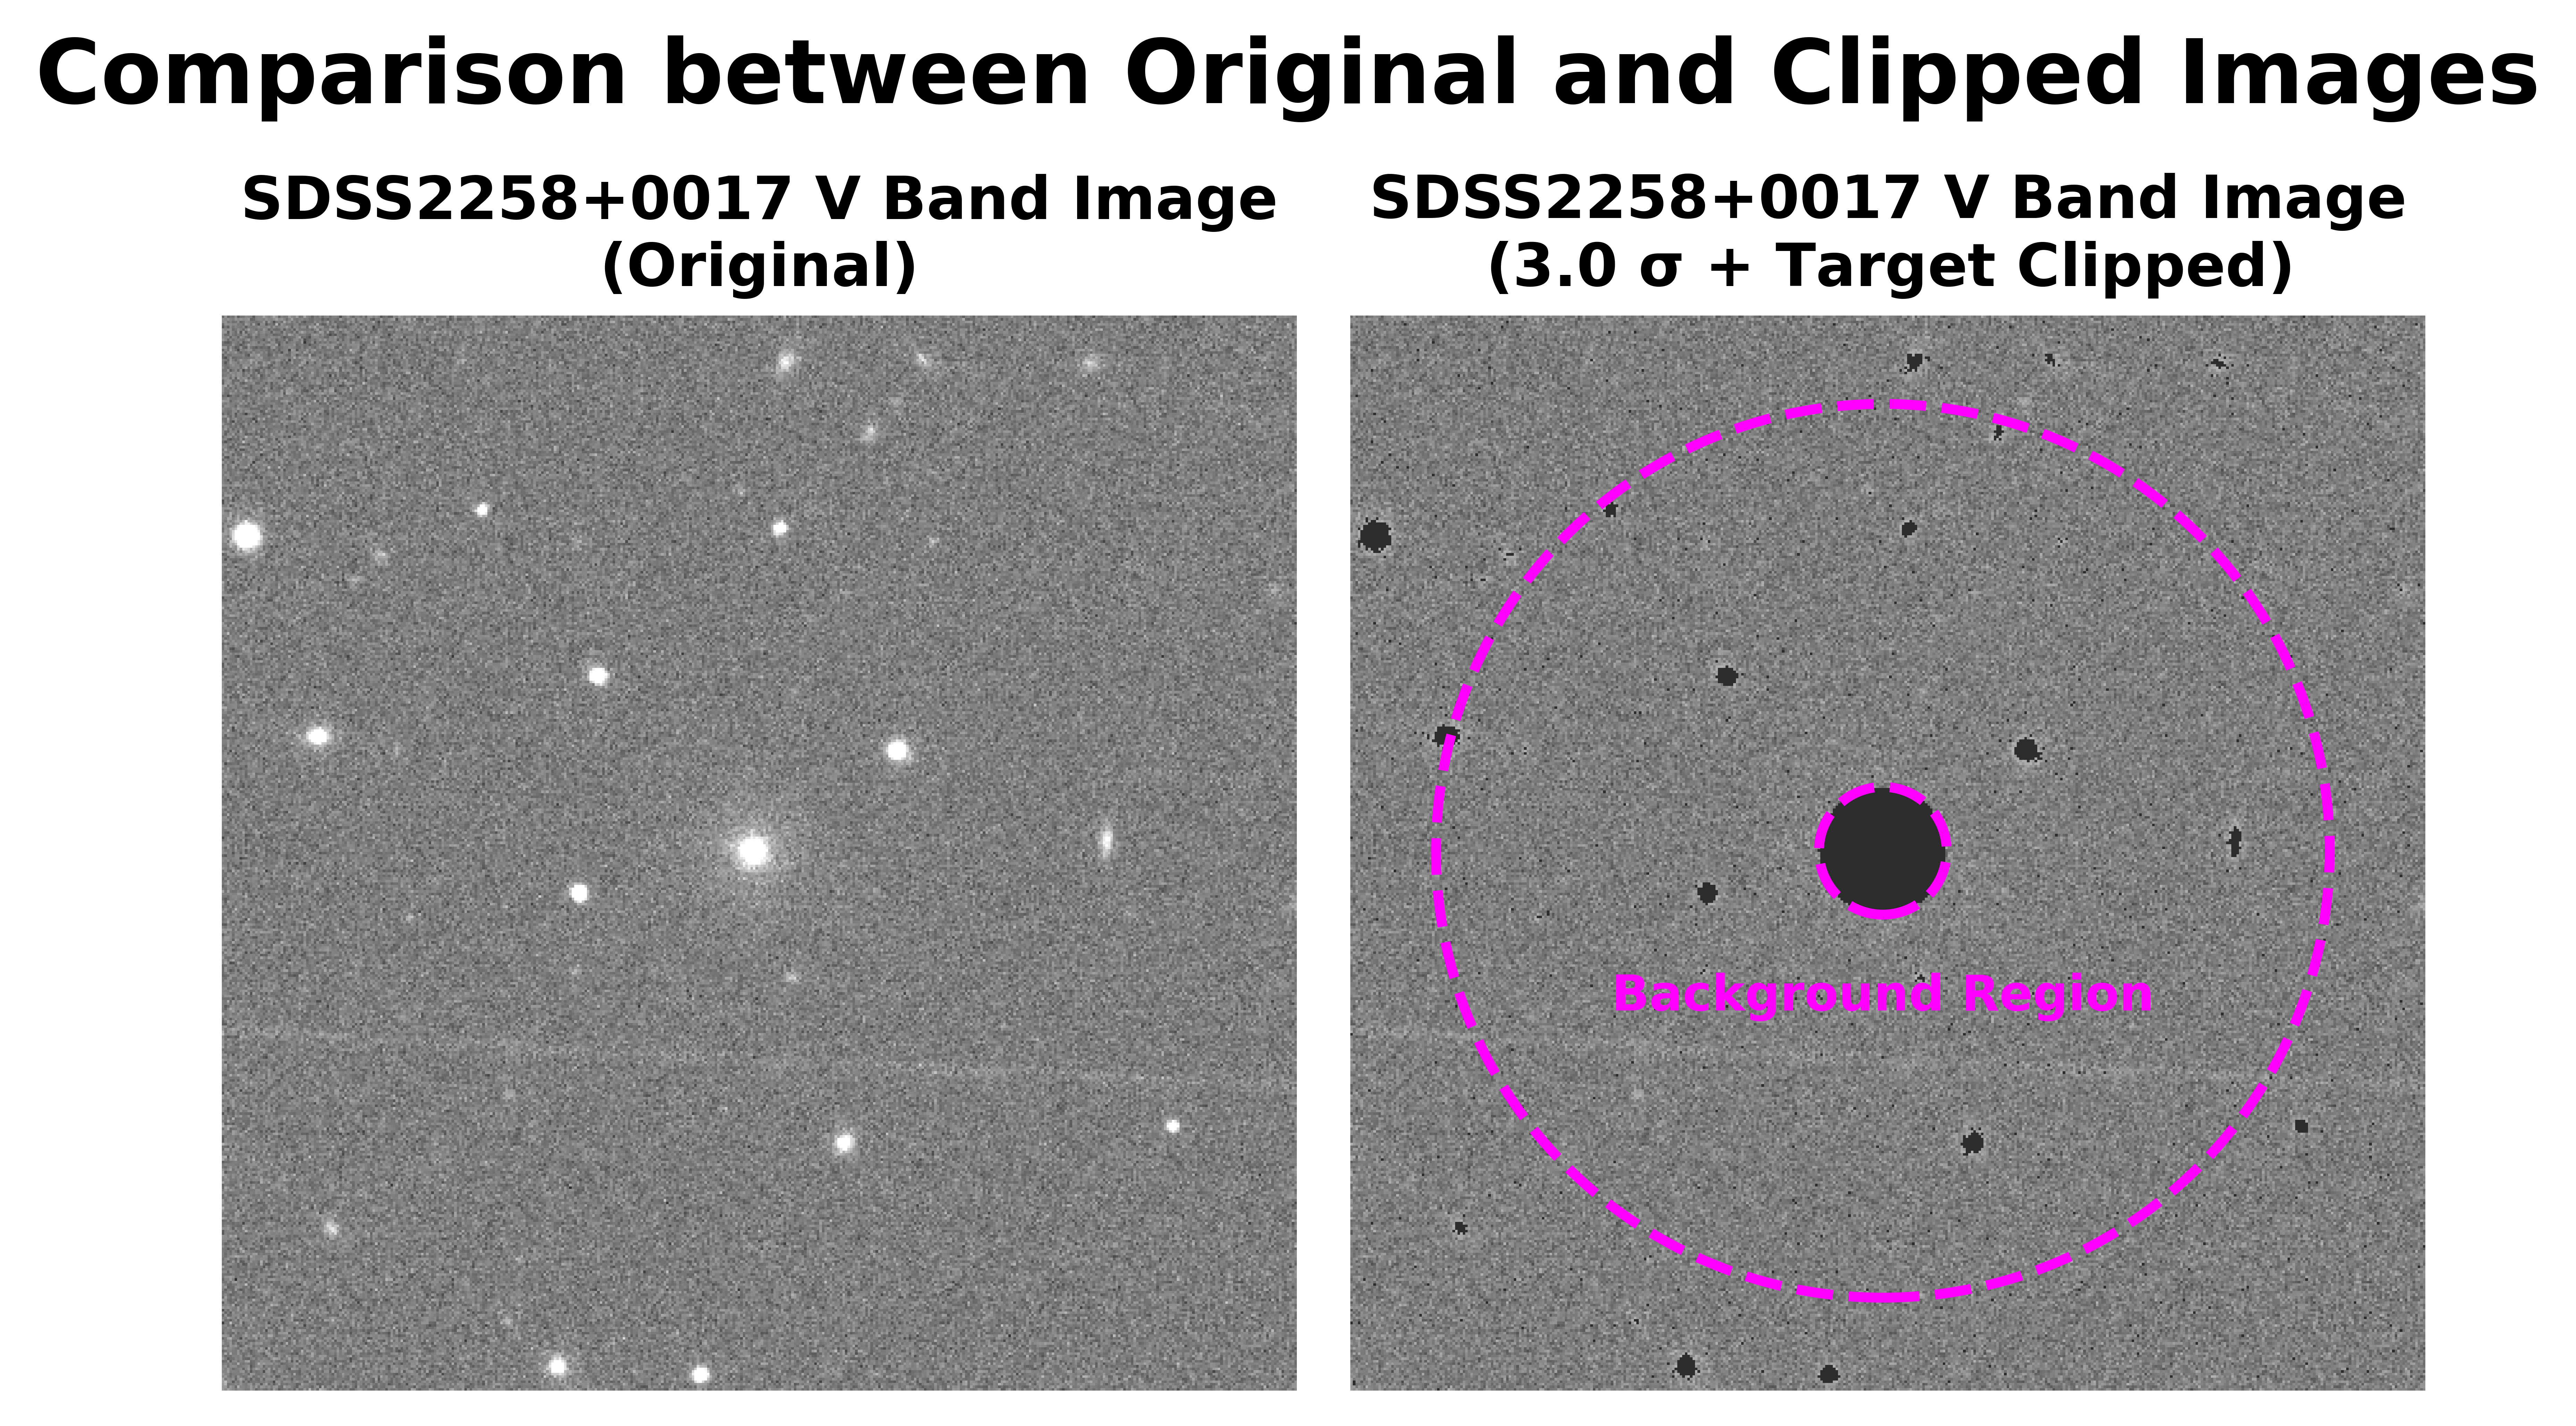

In [27]:
save_file_path                       = "./"
save_fig_name                        = "%s_%s_band_background_extraction_comparison_between_original_and_clipped.png"%(object_name, imag_header["FILTER"])
dpi                                  = 1024

imag_data_crop_clipped               = imag_data_crop.copy()
imag_data_crop_clipped[mask_clipped] = imag_data_crop.min()                              # plot only not-clipped part (but does not necessarily in the background mask); only for plotting purpose

fig = plt.figure(figsize=(8,4), dpi=dpi)
plt.subplots_adjust(wspace=0.05)
ax1 = plt.subplot(121)
plot_image(image_array=imag_data_crop, ax=ax1, cmap="gray", norm_type="linear", v_min=v_min, v_max=v_max, title="%s %s Band Image\n(Original)"%(object_name, imag_header["FILTER"]))

ax2 = plt.subplot(122)
plot_image(image_array=imag_data_crop_clipped, ax=ax2, cmap="gray", norm_type="log", v_min=v_min, v_max=v_max, title="%s %s Band Image\n(%.1f $\mathbf{\sigma}$ + Target Clipped)"%(object_name, imag_header["FILTER"], how_many_sigma))
object_circle     = plt.Circle(object_crop_center_pos_pixel, object_circle_radius,     color="magenta", lw=2.0, ls="--", fill=False)
background_circle = plt.Circle(object_crop_center_pos_pixel, background_circle_radius, color="magenta", lw=2.0, ls="--", fill=False)
ax2.add_patch(object_circle)
ax2.add_patch(background_circle)
ax2.text(x=object_crop_center_pos_pixel[0], y=object_crop_center_pos_pixel[1]-2.5*object_circle_radius, s="Background Region", color="magenta", weight="bold", fontsize=10., horizontalalignment="center")

fig.suptitle("Comparison between Original and Clipped Images", y=1.07, weight="heavy", fontsize=18.)

# plt.savefig("%s/%s"%(save_file_path,save_fig_name), bbox_inches='tight', dpi=dpi, pad_inches=0.02, facecolor='white', transparent=True)

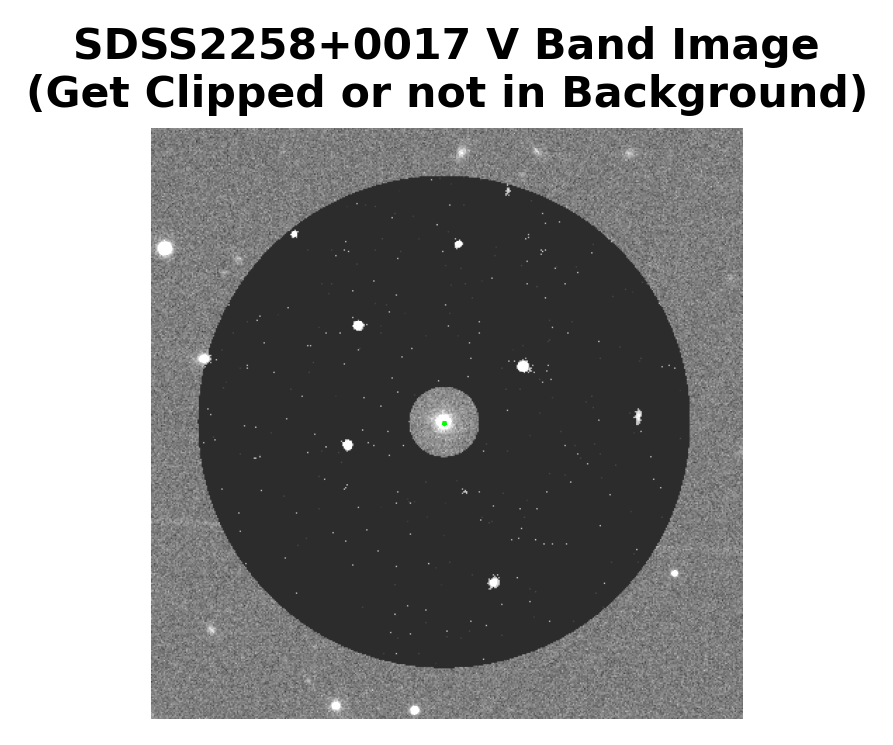

In [28]:
imag_data_crop_temp                                  = imag_data_crop.copy()
imag_data_crop_temp[~mask_clipped & background_mask] = imag_data_crop.min()

fig = plt.figure(figsize=(3,3), dpi=256)
ax  = plt.subplot(111)
plot_image(image_array=imag_data_crop_temp, ax=ax, cmap="gray", norm_type="linear", v_min=v_min, v_max=v_max, title="%s %s Band Image\n(Get Clipped or not in Background)"%(object_name, imag_header["FILTER"]))
ax.plot(object_crop_center_pos_pixel[0], object_crop_center_pos_pixel[1], marker="*", markersize=1.0, color="lime")

#### Use peak pixel brightness to make aperture masks (worse)

In [29]:
N_aperture                                 = 36
aperture_threshold_array                   = np.logspace(np.log10(4e-4), np.log10(0.95), N_aperture)

aperture_mask_list, aperture_pixel_count_array, brightness_sum_within_aperture_array, brightness_sum_error_within_aperture_array, brightness_peak\
                                           = do_aperture_photometric_by_peak_brightness(imag_array=imag_data_crop, object_mask=object_mask, aperture_threshold_array=aperture_threshold_array, background_brightness_mean=background_brightness_mean, background_brightness_mean_error=background_brightness_mean_error, background_brightness_std=background_brightness_std, verbose=False)

brightness_sum_within_aperture_full        = brightness_sum_within_aperture_array.max()
interp_func_aperture_size_to_bightness_sum = interp1d(brightness_sum_within_aperture_array, aperture_pixel_count_array)
aperture_pixel_count_half_brightness       = interp_func_aperture_size_to_bightness_sum(0.5*brightness_sum_within_aperture_full)
signal_to_noise_ratio_array                = brightness_sum_within_aperture_array/brightness_sum_error_within_aperture_array

index_max                                  = np.argmax(brightness_sum_within_aperture_array)
print("Total brightness within the aperture mask satureats at %.4e ± %.4e %s."%(brightness_sum_within_aperture_array[index_max], brightness_sum_error_within_aperture_array[index_max], "UNIT"))
print("Squre root of mask size enclosed half of the stauration total brightness is %.2f pixels."%(np.sqrt(aperture_pixel_count_half_brightness)))

Total brightness within the aperture mask satureats at 1.6673e-03 ± 1.7499e-05 UNIT.
Squre root of mask size enclosed half of the stauration total brightness is 13.12 pixels.


Text(0.5, 0.95, 'Aperture Mask Shapes for Different Thresholds (V Band)')

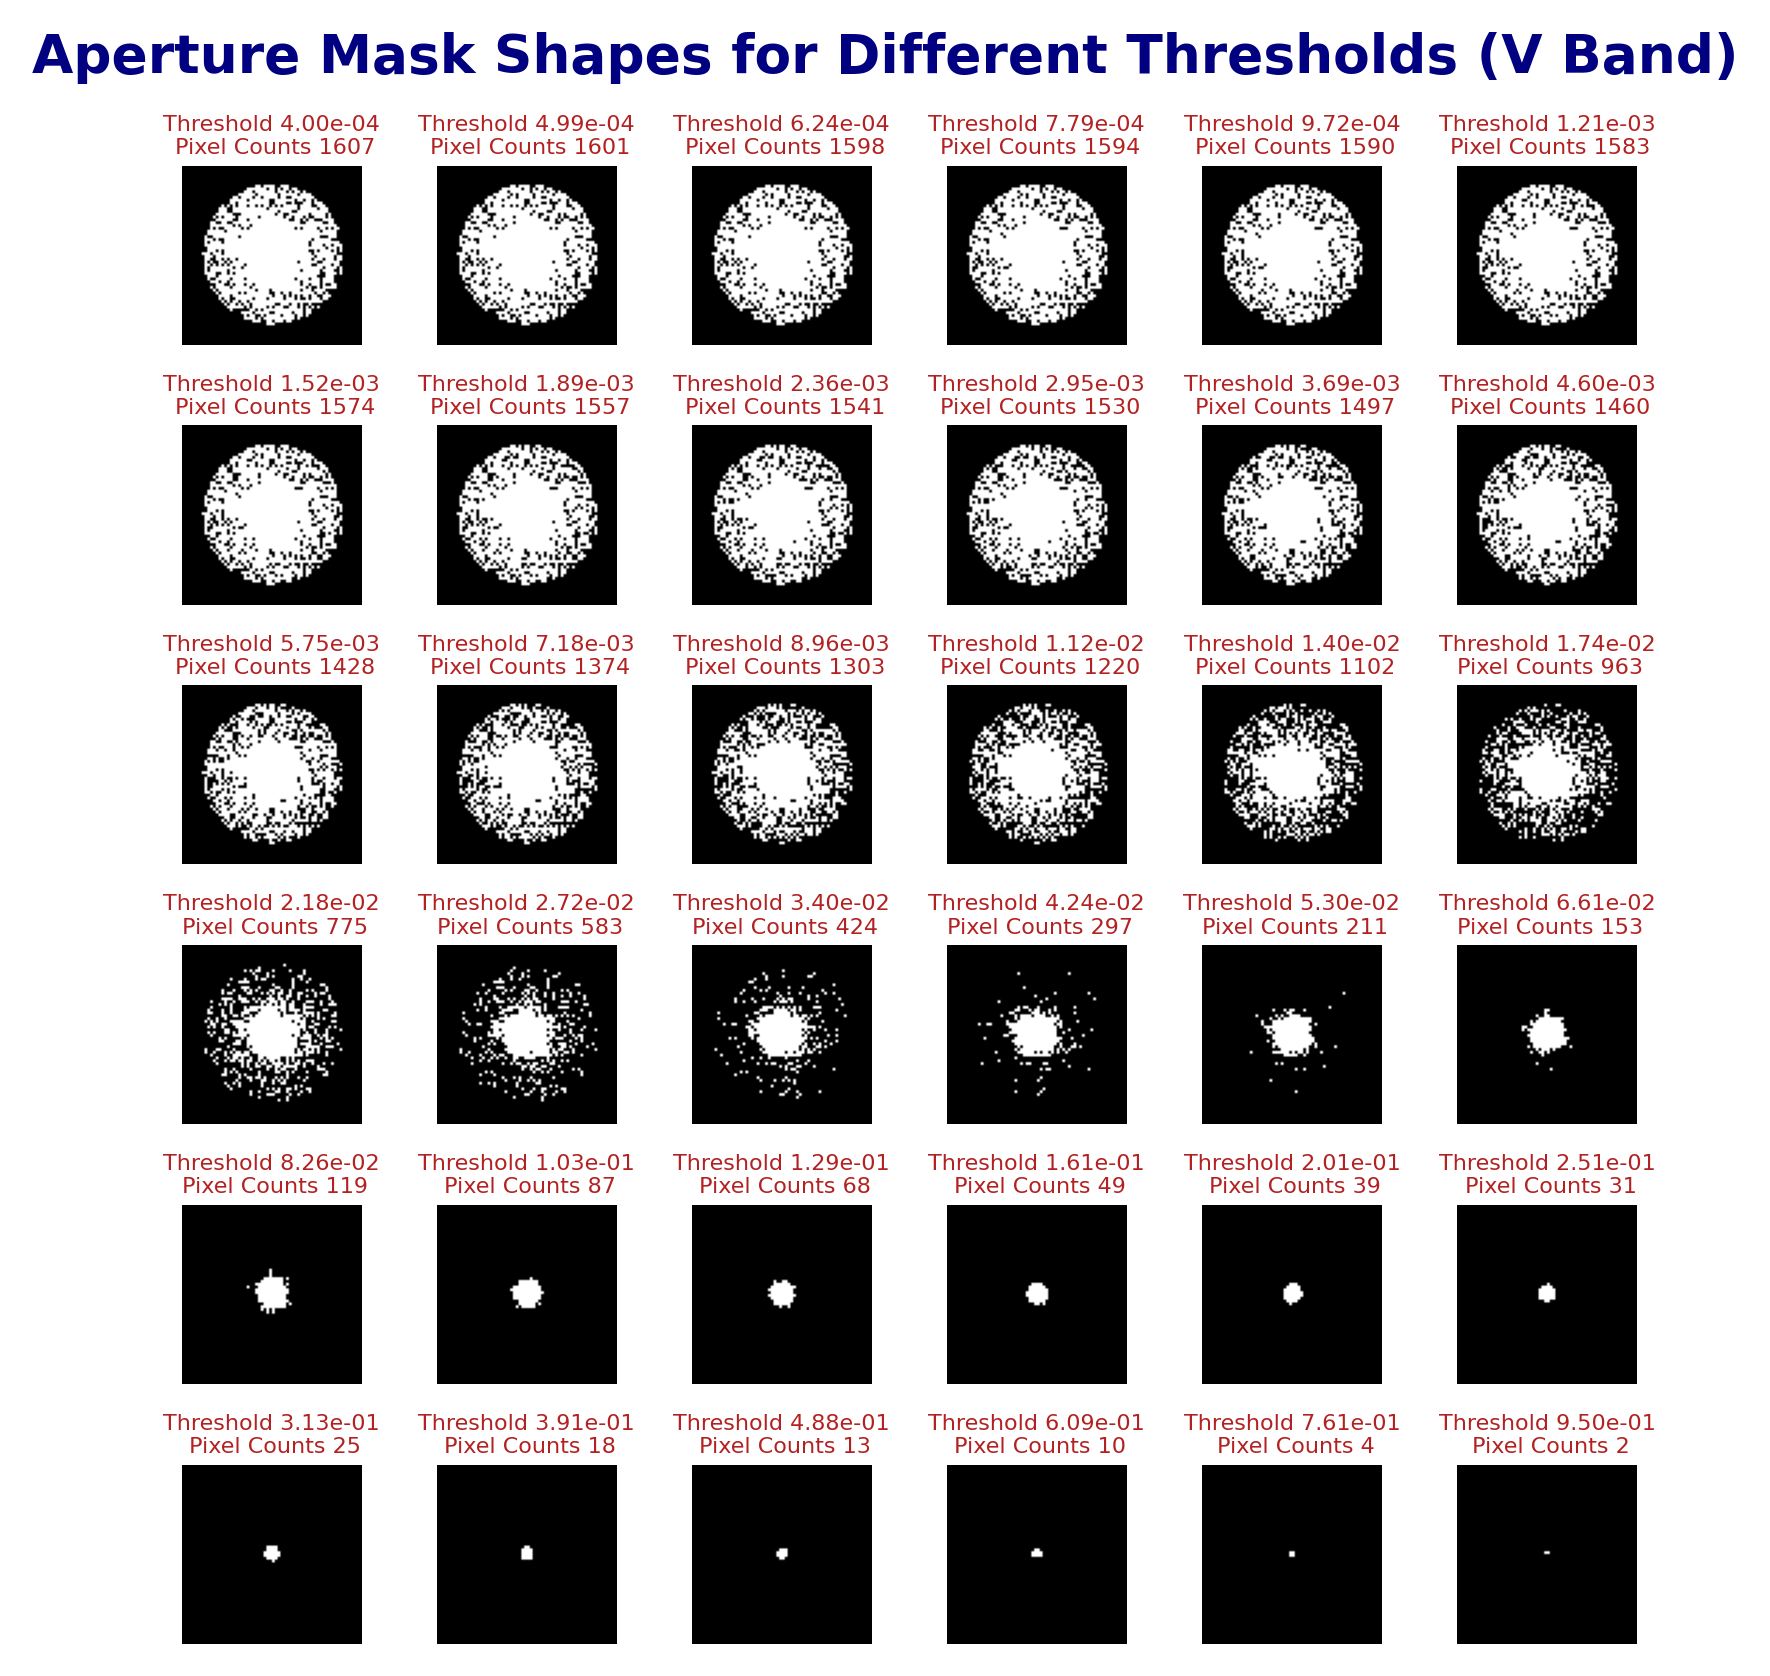

In [30]:
ax_list_row_number    = 6
ax_list_column_number = 6
crop_size             = 32
save_file_path        = "./photo_gallery/"

fig, ax_list = plt.subplots(figsize=(6,6), dpi=320, nrows=ax_list_row_number, ncols=ax_list_column_number)
plt.subplots_adjust(hspace=0.45)

for n_row in range(ax_list_row_number):
    for n_col in range(ax_list_column_number):
        index_temp                    = n_row*ax_list_column_number + n_col
        ax_temp                       = ax_list[n_row][n_col]
        aperture_mask_temp            = aperture_mask_list[index_temp]
        
        imag_temp                = np.ones_like(imag_data_crop)
        imag_temp[~object_mask]  = 0.0
        imag_temp[object_mask]  *= aperture_mask_temp
        # imag_temp                = np.sign(imag_temp) # conver to 0/1; 0: exluded by the mask, 1: included by the mask
        
        center_index                  = np.array([np.int32(np.round(object_crop_center_pos_pixel[0])), np.int32(np.round(object_crop_center_pos_pixel[1]))])
        plot_image(imag_temp[center_index[1]-crop_size:center_index[1]+crop_size, center_index[0]-crop_size:center_index[0]+crop_size],\
                   ax=ax_temp, cmap="gray", norm_type="linear", v_min=0, v_max=1, title="")
        ax_temp.set_title("Threshold %.2e\n Pixel Counts %d"%(aperture_threshold_array[index_temp],aperture_pixel_count_array[index_temp]), fontsize=5.0, y=0.92, color="firebrick")
fig.suptitle("Aperture Mask Shapes for Different Thresholds (%s Band)"%imag_header["FILTER"], weight='bold', y=0.95, color="Navy")

# plt.savefig("%s/%s_%s_band_aperture_mask_shape_vs_different_threshold.png"%(save_file_path, object_name, imag_header["FILTER"]), bbox_inches='tight', dpi=dpi, pad_inches=0.02, facecolor='white', transparent=True)

Text(0.5, 1.01, 'Background Noise Dominance')

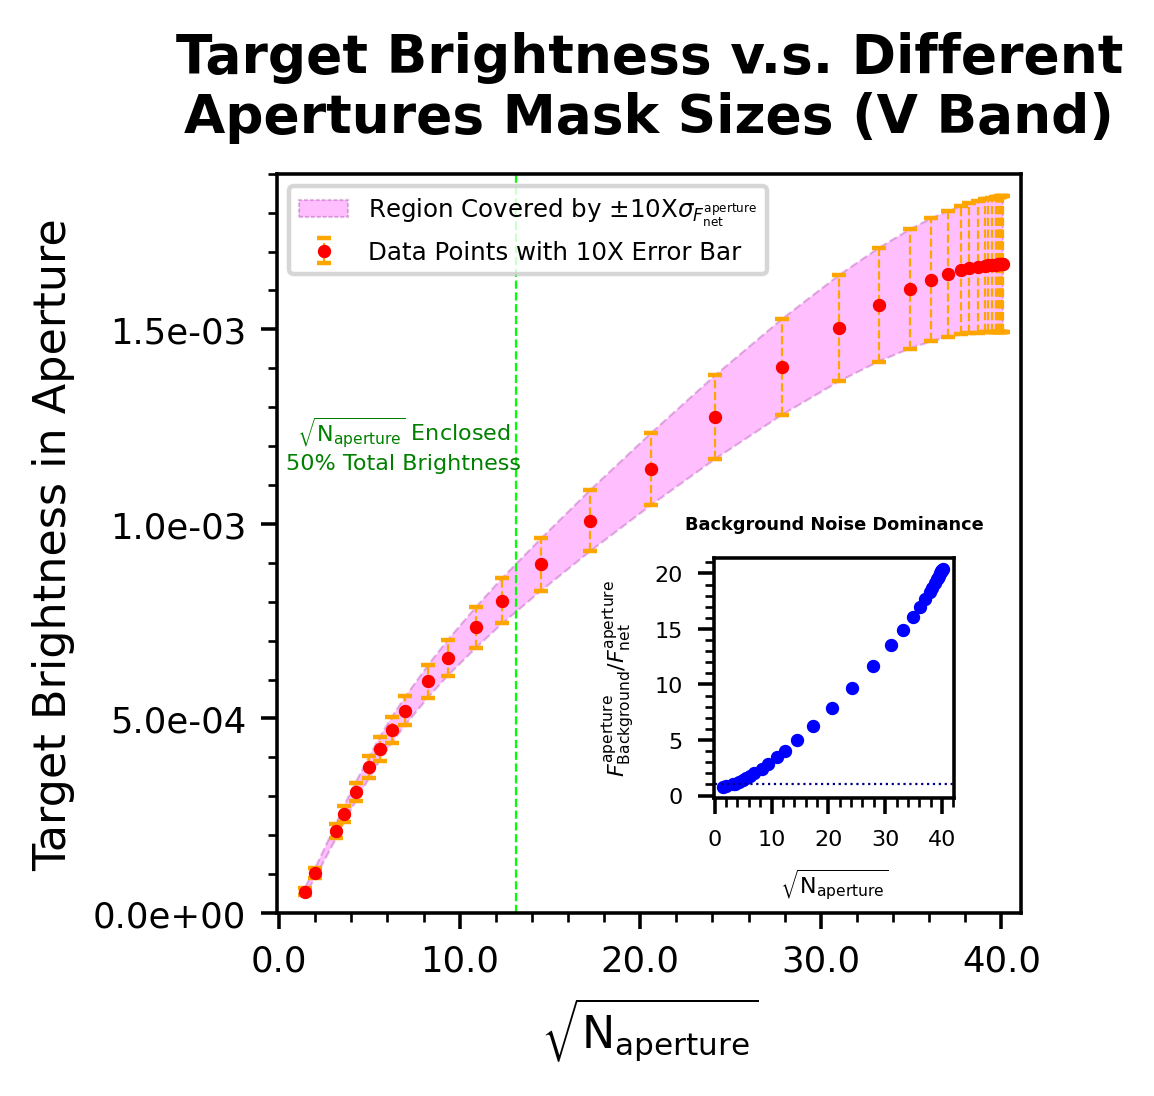

In [31]:
# reference for changing the errorbar line style: https://stackoverflow.com/questions/22995797/can-matplotlib-errorbars-have-a-linestyle-set
errorbar_enlarge = 10.0
save_file_path   = "./photo_gallery/"

fig = plt.figure(figsize=(3,3), dpi=320)
ax  = plt.subplot(111)

eb  = ax.errorbar(np.sqrt(aperture_pixel_count_array), brightness_sum_within_aperture_array, errorbar_enlarge*brightness_sum_error_within_aperture_array,\
                  lw=0.0, color='red', marker='o', markersize=2.0, capsize=1.5, mew=1.0, ls ="", label='Data Points with %.0fX Error Bar'%errorbar_enlarge, \
                  ecolor='orange', elinewidth=1.0, barsabove=False)
eb[-1][0].set_linestyle('--')
eb[-1][0].set_linewidth(0.5)
ax.fill_between(np.sqrt(aperture_pixel_count_array), brightness_sum_within_aperture_array-errorbar_enlarge*brightness_sum_error_within_aperture_array,\
                brightness_sum_within_aperture_array+errorbar_enlarge*brightness_sum_error_within_aperture_array,\
                facecolor='magenta', edgecolor='purple', ls="--", lw=0.5, alpha=0.25, label='Region Covered by $\pm %.0f\mathrm{X}\sigma_{F_{\mathrm{net}}^{\mathrm{aperture}}}$'%errorbar_enlarge)
ax.plot([np.sqrt(aperture_pixel_count_half_brightness)]*2, [0.0, 2.0e-3], lw=0.5, ls="--", color="lime")
ax.text(0.17, 0.6, "$\mathrm{\sqrt{N_{\\text{aperture}}}}$ Enclosed\n50% Total Brightness", color="green", fontsize=5., transform=ax.transAxes, horizontalalignment="center")

ax.set_xticks(np.arange(0.0, 41.0, 10.0))
ax.set_xticklabels(np.arange(0.0, 41.0, 10.0), fontsize=8.0)
ax.set_yticks(np.arange(0.0, 2.1e-3, 5e-4))
ax.set_yticklabels(np.arange(0.0, 2.1e-3, 5e-4), fontsize=8.0)
ax.xaxis.set_minor_locator(MultipleLocator(2.0))
ax.yaxis.set_minor_locator(MultipleLocator(1e-4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.set_xlabel("$\mathrm{\sqrt{N_{\\text{aperture}}}}$",  fontsize=10.0)
ax.set_ylabel("Target Brightness in Aperture", fontsize=10.0)
ax.set_xlim([-0.1, 41.1])
ax.set_ylim([ 0.0, 1.9e-3])

ax.legend(loc='upper left', prop={'size':5.5})
ax.set_title("Target Brightness v.s. Different\nApertures Mask Sizes (%s Band)"%imag_header["FILTER"], fontsize=12., y=1.02, weight="bold")

ax_inset = fig.add_axes([0.58, 0.23, 0.25, 0.25])
ax_inset.plot(np.sqrt(aperture_pixel_count_array),\
              background_brightness_mean*aperture_pixel_count_array/brightness_sum_within_aperture_array,\
              lw=0.0, color="blue", marker='o', markersize=2.0)
ax_inset.plot([0.0, 50.0], [1.0, 1.0], color="navy", lw=0.5, ls=":")
ax_inset.set_xticks(np.arange(0.0, 41.0, 10.0))
ax_inset.set_xticklabels(np.arange(0.0, 41.0, 10.0), fontsize=5.0)
ax_inset.set_yticks(np.arange(0.0, 20.1, 5.0))
ax_inset.set_yticklabels(np.arange(0.0, 20.1, 5.0), fontsize=5.0)
ax_inset.set_xlim([-0.1, 42.1])
ax_inset.xaxis.set_minor_locator(MultipleLocator(2.0))
ax_inset.yaxis.set_minor_locator(MultipleLocator(1.0))
ax_inset.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_inset.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_inset.set_xlabel("$\mathrm{\sqrt{N_{\\text{aperture}}}}$",  fontsize=5.0)
ax_inset.set_ylabel("$F_{\\text{Background}}^{\mathrm{aperture}}/F_{\\text{net}}^{\mathrm{aperture}}$", fontsize=5.0)
ax_inset.set_title("Background Noise Dominance", fontsize=4.0, y=1.01, weight="bold")

# plt.savefig("%s/%s_%s_band_target_brightness_vs_different_aperture_mask.png"%(save_file_path, object_name, imag_header["FILTER"]), bbox_inches='tight', dpi=dpi, pad_inches=0.02, facecolor='white', transparent=True)

Text(0.5, 1.02, 'S/N Ratio v.s. Different Apertures\nMask Sizes (V BAND)')

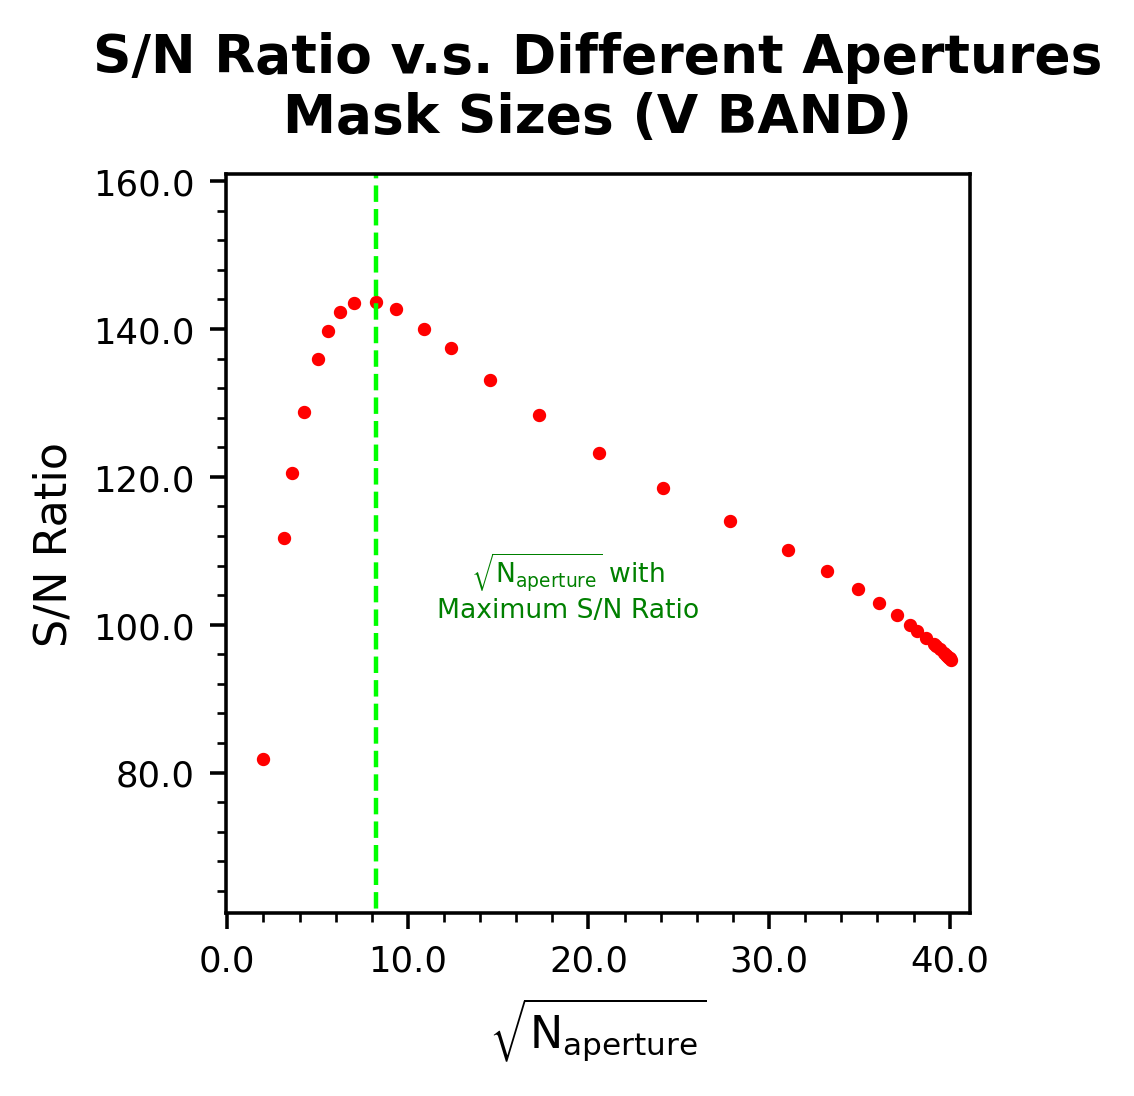

In [32]:
save_file_path = "./photo_gallery/"
fig            = plt.figure(figsize=(3,3), dpi=320)
ax             = plt.subplot(111)

ax.plot(np.sqrt(aperture_pixel_count_array), signal_to_noise_ratio_array, lw=0.0, marker="o", markersize=2.0, color="red")
ax.plot([np.sqrt(aperture_pixel_count_array[np.argmax(signal_to_noise_ratio_array)])]*2, [25.0, 180.0], lw=1.0, ls="--", color="lime")
ax.text(0.46, 0.4, "$\mathrm{\sqrt{N_{\\text{aperture}}}}$ with\nMaximum S/N Ratio", color="green", fontsize=6., transform=ax.transAxes, horizontalalignment="center")

ax.set_xticks(np.arange(0.0, 41.0, 10.0))
ax.set_xticklabels(np.arange(0.0, 41.0, 10.0), fontsize=8.0)
ax.set_yticks(np.arange(0.0, 161.0, 20.0))
ax.set_yticklabels(np.arange(0.0, 161.0, 20.0), fontsize=8.0)
ax.xaxis.set_minor_locator(MultipleLocator(2.0))
ax.yaxis.set_minor_locator(MultipleLocator(4.0))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_xlabel("$\mathrm{\sqrt{N_{\\text{aperture}}}}$",  fontsize=10.0)
ax.set_ylabel("S/N Ratio", fontsize=10.0)
ax.set_xlim([-0.1, 41.1])
ax.set_ylim([61.0, 161.0])

ax.set_title("S/N Ratio v.s. Different Apertures\nMask Sizes (%s BAND)"%imag_header["FILTER"], fontsize=12., y=1.02, weight="bold")
# plt.savefig("%s/%s_%s_band_signal_to_noise_ratio_vs_different_aperture_mask.png"%(save_file_path, object_name, imag_header["FILTER"]), bbox_inches='tight', dpi=dpi, pad_inches=0.02, facecolor='white', transparent=True)

#### Use radius to make spherical aperture masks (better)

In [33]:
N_aperture                                 = 25
aperture_radius_array                      = np.linspace(1, object_circle_radius, N_aperture)

aperture_mask_list, aperture_pixel_count_array, brightness_sum_within_aperture_array, brightness_sum_error_within_aperture_array\
                                           = do_aperture_photometric_by_radius(imag_array=imag_data_crop, object_mask=object_mask, aperture_radius_array=aperture_radius_array, object_center_pos=object_crop_center_pos_pixel, background_brightness_mean=background_brightness_mean, background_brightness_mean_error=background_brightness_mean_error, background_brightness_std=background_brightness_std, verbose=True)

brightness_sum_within_aperture_full        = brightness_sum_within_aperture_array.max()
interp_func_aperture_size_to_bightness_sum = interp1d(brightness_sum_within_aperture_array, aperture_pixel_count_array)
aperture_pixel_count_half_brightness       = interp_func_aperture_size_to_bightness_sum(0.5*brightness_sum_within_aperture_full)
signal_to_noise_ratio_array                = brightness_sum_within_aperture_array/brightness_sum_error_within_aperture_array

index_max                                  = np.argmax(brightness_sum_within_aperture_array)
print("Total brightness within the aperture mask satureats at %.4e ± %.4e %s."%(brightness_sum_within_aperture_array[index_max], brightness_sum_error_within_aperture_array[index_max], "UNIT"))
print("Squre root of mask size enclosed half of the stauration total brightness is %.2f pixels."%(np.sqrt(aperture_pixel_count_half_brightness)))

Aperture radius = 1.00:
	Pixel counts in the aperture mask is 2 .
	Total Brightness within the aperture mask is 5.1872e-05 ± 8.9157e-07 UNIT .
----------------------------------------------------------------------------------------------------
Aperture radius = 2.00:
	Pixel counts in the aperture mask is 11 .
	Total Brightness within the aperture mask is 2.2251e-04 ± 1.9603e-06 UNIT .
----------------------------------------------------------------------------------------------------
Aperture radius = 3.00:
	Pixel counts in the aperture mask is 27 .
	Total Brightness within the aperture mask is 3.8783e-04 ± 2.8456e-06 UNIT .
----------------------------------------------------------------------------------------------------
Aperture radius = 4.00:
	Pixel counts in the aperture mask is 49 .
	Total Brightness within the aperture mask is 5.1764e-04 ± 3.6232e-06 UNIT .
----------------------------------------------------------------------------------------------------
Aperture radius = 5.0

Text(0.5, 0.95, 'Aperture Mask Shapes for Different Radius (V Band)')

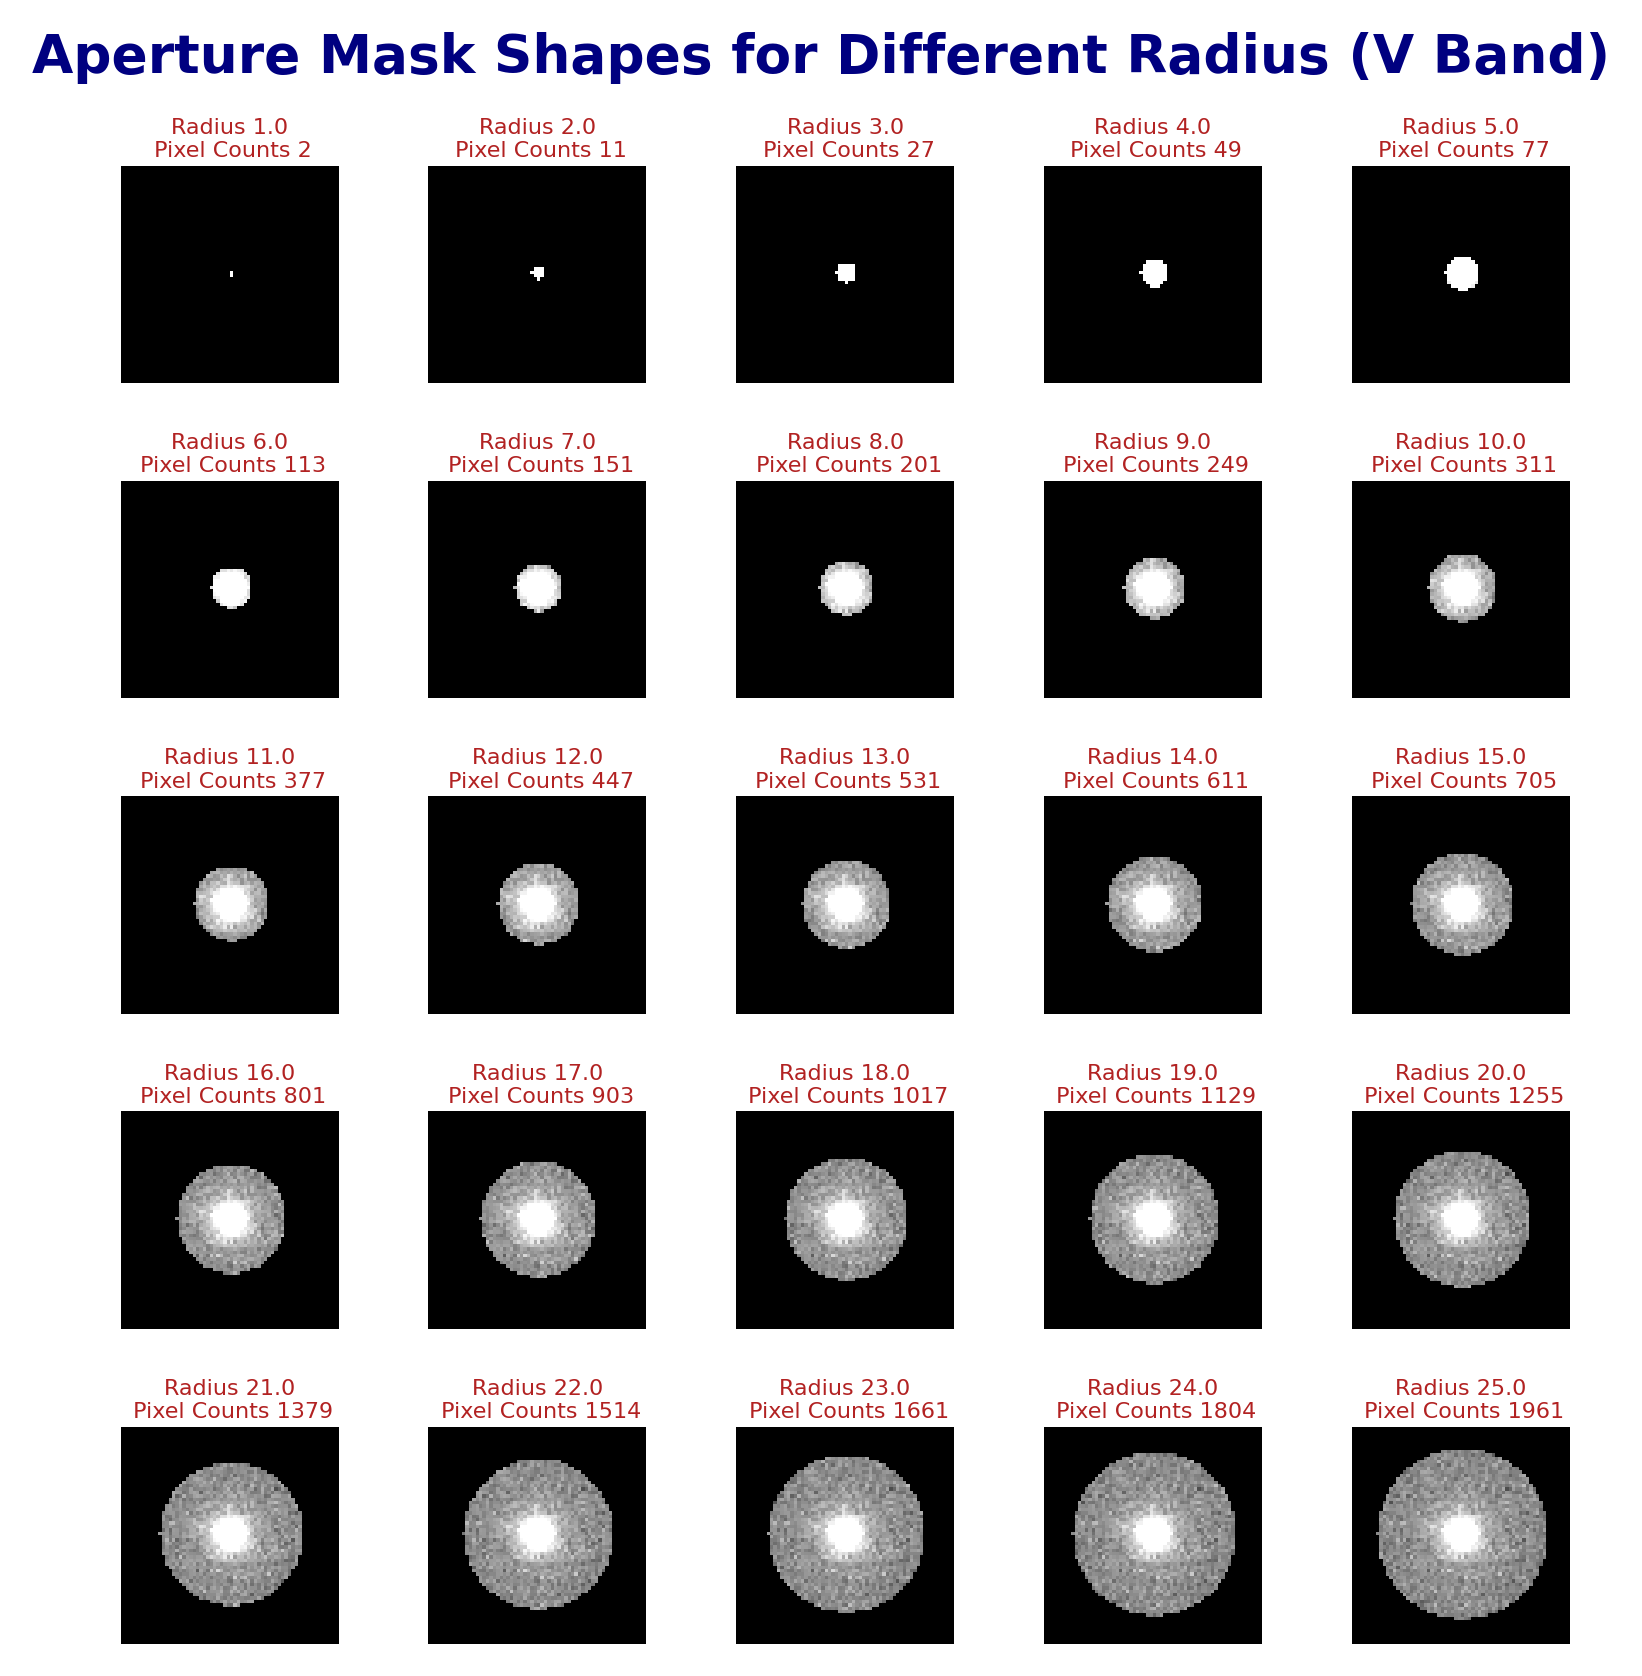

In [34]:
ax_list_row_number    = 5
ax_list_column_number = 5
crop_size             = 32
save_file_path        = "./photo_gallery/"

fig, ax_list = plt.subplots(figsize=(6,6), dpi=320, nrows=ax_list_row_number, ncols=ax_list_column_number)
plt.subplots_adjust(hspace=0.45)

for n_row in range(ax_list_row_number):
    for n_col in range(ax_list_column_number):
        index_temp                    = n_row*ax_list_column_number + n_col
        ax_temp                       = ax_list[n_row][n_col]
        aperture_mask_temp            = aperture_mask_list[index_temp]
        
        imag_temp                = np.ones_like(imag_data_crop)
        imag_temp[~object_mask]  = 0.0
        imag_temp[object_mask]  *= aperture_mask_temp
        imag_temp               *= imag_data_crop
        # imag_temp                = np.sign(imag_temp) # conver to 0/1; 0: exluded by the mask, 1: included by the mask
        
        center_index                  = np.array([np.int32(np.round(object_crop_center_pos_pixel[0])), np.int32(np.round(object_crop_center_pos_pixel[1]))])
        plot_image(imag_temp[center_index[1]-crop_size:center_index[1]+crop_size, center_index[0]-crop_size:center_index[0]+crop_size],\
                   ax=ax_temp, cmap="gray", norm_type="linear", v_min=v_min, v_max=v_max, title="")
        # ax_temp.plot(crop_size+object_crop_center_pos_pixel[0]-center_index[0], crop_size+object_crop_center_pos_pixel[1]-center_index[1],  marker="*", markersize=0.1, color="lime")
        ax_temp.set_title("Radius %.1f\n Pixel Counts %d"%(aperture_radius_array[index_temp],aperture_pixel_count_array[index_temp]), fontsize=5.0, y=0.92, color="firebrick")
fig.suptitle("Aperture Mask Shapes for Different Radius (%s Band)"%imag_header["FILTER"], weight='bold', y=0.95, color="Navy")

# plt.savefig("%s/%s_%s_band_aperture_mask_shape_vs_different_radius.png"%(save_file_path, object_name, imag_header["FILTER"]), bbox_inches='tight', dpi=dpi, pad_inches=0.02, facecolor='white', transparent=True)

Text(0.5, 1.01, 'Background Noise Dominance')

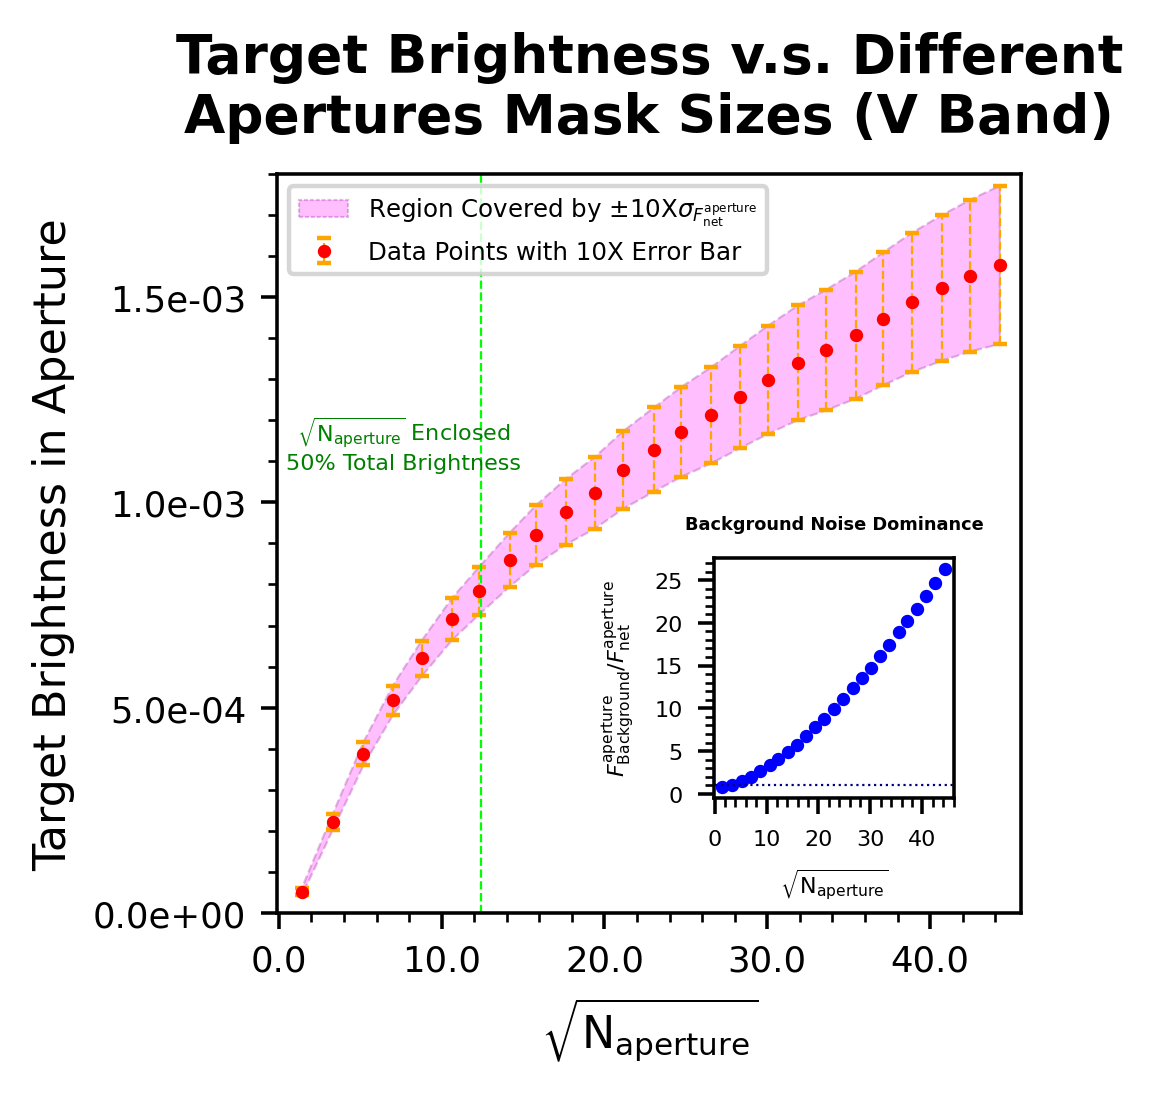

In [35]:
# reference for changing the errorbar line style: https://stackoverflow.com/questions/22995797/can-matplotlib-errorbars-have-a-linestyle-set
save_file_path   = "./photo_gallery/"
errorbar_enlarge = 10.0

fig = plt.figure(figsize=(3,3), dpi=320)
ax  = plt.subplot(111)

eb  = ax.errorbar(np.sqrt(aperture_pixel_count_array), brightness_sum_within_aperture_array, errorbar_enlarge*brightness_sum_error_within_aperture_array,\
                  lw=0.0, color='red', marker='o', markersize=2.0, capsize=1.5, mew=1.0, ls ="", label='Data Points with %.0fX Error Bar'%errorbar_enlarge, \
                  ecolor='orange', elinewidth=1.0, barsabove=False)
eb[-1][0].set_linestyle('--')
eb[-1][0].set_linewidth(0.5)
ax.fill_between(np.sqrt(aperture_pixel_count_array), brightness_sum_within_aperture_array-errorbar_enlarge*brightness_sum_error_within_aperture_array,\
                brightness_sum_within_aperture_array+errorbar_enlarge*brightness_sum_error_within_aperture_array,\
                facecolor='magenta', edgecolor='purple', ls="--", lw=0.5, alpha=0.25, label='Region Covered by $\pm %.0f\mathrm{X}\sigma_{F_{\mathrm{net}}^{\mathrm{aperture}}}$'%errorbar_enlarge)
ax.plot([np.sqrt(aperture_pixel_count_half_brightness)]*2, [0.0, 2.0e-3], lw=0.5, ls="--", color="lime")
ax.text(0.17, 0.6, "$\mathrm{\sqrt{N_{\\text{aperture}}}}$ Enclosed\n50% Total Brightness", color="green", fontsize=5.0, transform=ax.transAxes, horizontalalignment="center")

ax.set_xticks(np.arange(0.0, 41.0, 10.0))
ax.set_xticklabels(np.arange(0.0, 41.0, 10.0), fontsize=8.0)
ax.set_yticks(np.arange(0.0, 2.1e-3, 5e-4))
ax.set_yticklabels(np.arange(0.0, 2.1e-3, 5e-4), fontsize=8.0)
ax.xaxis.set_minor_locator(MultipleLocator(2.0))
ax.yaxis.set_minor_locator(MultipleLocator(1e-4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.set_xlabel("$\mathrm{\sqrt{N_{\\text{aperture}}}}$",  fontsize=10.0)
ax.set_ylabel("Target Brightness in Aperture", fontsize=10.0)
ax.set_xlim([-0.1, 45.6])
ax.set_ylim([ 0.0, 1.8e-3])

ax.legend(loc='upper left', prop={'size':5.5})
ax.set_title("Target Brightness v.s. Different\nApertures Mask Sizes (%s Band)"%imag_header["FILTER"], fontsize=12., y=1.02, weight="bold")

ax_inset = fig.add_axes([0.58, 0.23, 0.25, 0.25])
ax_inset.plot(np.sqrt(aperture_pixel_count_array),\
              background_brightness_mean*aperture_pixel_count_array/brightness_sum_within_aperture_array,\
              lw=0.0, color="blue", marker='o', markersize=2.0)
ax_inset.plot([0.0, 50.0], [1.0, 1.0], color="navy", lw=0.5, ls=":")
ax_inset.set_xticks(np.arange(0.0, 41.0, 10.0))
ax_inset.set_xticklabels(np.arange(0.0, 41.0, 10.0), fontsize=5.0)
ax_inset.set_yticks(np.arange(0.0, 25.1, 5.0))
ax_inset.set_yticklabels(np.arange(0.0, 25.1, 5.0), fontsize=5.0)
ax_inset.set_xlim([-0.1, 46.1])
ax_inset.xaxis.set_minor_locator(MultipleLocator(2.0))
ax_inset.yaxis.set_minor_locator(MultipleLocator(1.0))
ax_inset.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_inset.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_inset.set_xlabel("$\mathrm{\sqrt{N_{\\text{aperture}}}}$",  fontsize=5.0)
ax_inset.set_ylabel("$F_{\\text{Background}}^{\mathrm{aperture}}/F_{\\text{net}}^{\mathrm{aperture}}$", fontsize=5.0)
ax_inset.set_title("Background Noise Dominance", fontsize=4.0, y=1.01, weight="bold")

# plt.savefig("%s/%s_%s_band_brightness_vs_different_aperture_radius.png"%(save_file_path, object_name, imag_header["FILTER"]), bbox_inches='tight', dpi=dpi, pad_inches=0.02, facecolor='white', transparent=True)

Text(0.5, 1.02, 'S/N Ratio v.s. Different Apertures\nMask Sizes (V BAND)')

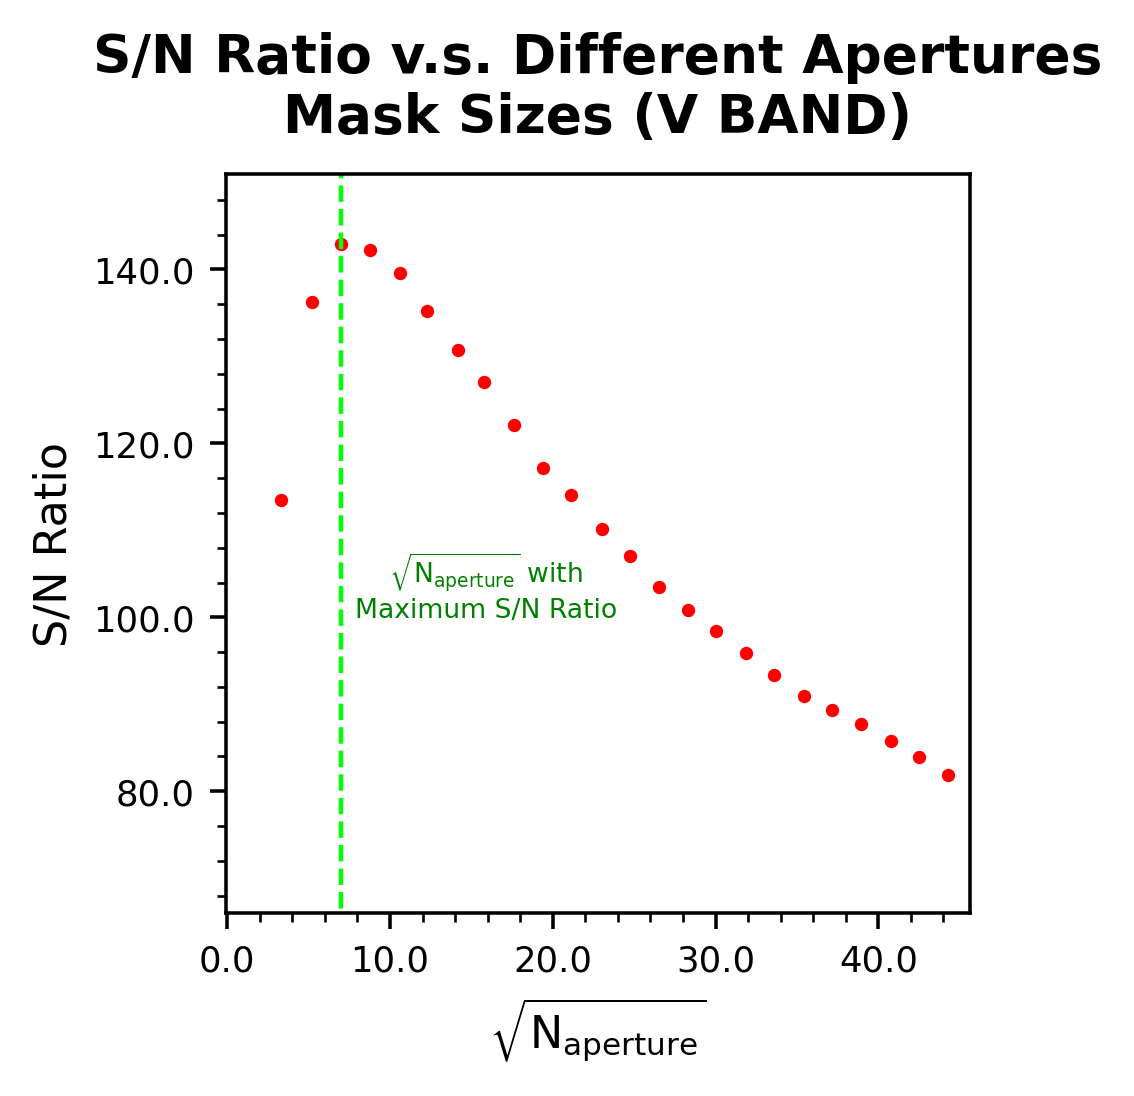

In [36]:
save_file_path = "./photo_gallery/"
fig            = plt.figure(figsize=(3,3), dpi=320)
ax             = plt.subplot(111)

ax.plot(np.sqrt(aperture_pixel_count_array), signal_to_noise_ratio_array, lw=0.0, marker="o", markersize=2.0, color="red")
ax.plot([np.sqrt(aperture_pixel_count_array[np.argmax(signal_to_noise_ratio_array)])]*2, [25.0, 180.0], lw=1.0, ls="--", color="lime")
ax.text(0.35, 0.4, "$\mathrm{\sqrt{N_{\\text{aperture}}}}$ with\nMaximum S/N Ratio", color="green", fontsize=6., transform=ax.transAxes, horizontalalignment="center")

ax.set_xticks(np.arange(0.0, 41.0, 10.0))
ax.set_xticklabels(np.arange(0.0, 41.0, 10.0), fontsize=8.0)
ax.set_yticks(np.arange(0.0, 161.0, 20.0))
ax.set_yticklabels(np.arange(0.0, 161.0, 20.0), fontsize=8.0)
ax.xaxis.set_minor_locator(MultipleLocator(2.0))
ax.yaxis.set_minor_locator(MultipleLocator(4.0))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_xlabel("$\mathrm{\sqrt{N_{\\text{aperture}}}}$",  fontsize=10.0)
ax.set_ylabel("S/N Ratio", fontsize=10.0)
ax.set_xlim([-0.1, 45.6])
ax.set_ylim([66.0, 151.0])

ax.set_title("S/N Ratio v.s. Different Apertures\nMask Sizes (%s BAND)"%imag_header["FILTER"], fontsize=12., y=1.02, weight="bold")
# plt.savefig("%s/%s_%s_band_signal_to_noise_ratio_vs_different_aperture_radius.png"%(save_file_path, object_name, imag_header["FILTER"]), bbox_inches='tight', dpi=dpi, pad_inches=0.02, facecolor='white', transparent=True)

In [37]:
max_id = np.argmax(brightness_sum_within_aperture_array)
print("%.8e + %.8e"%(brightness_sum_within_aperture_array.max(), brightness_sum_error_within_aperture_array[max_id]))
with open(m_inst_V_band_filename_max, "w") as f:
    f.write("# APERTURE_SIZE\tTOTAL_BRIGHTNESS\tERROR_TOTAL_BRIGHTNESS\n")
    f.write("%.2f\t%.8e\t%.8e"%(np.sqrt(aperture_pixel_count_array[max_id]), brightness_sum_within_aperture_array[max_id], brightness_sum_error_within_aperture_array[max_id]))

1.57811563e-03 + 1.92646010e-05


In [38]:
saturated_criteria = 0.02
increase_rate      = (brightness_sum_within_aperture_array[1:]-brightness_sum_within_aperture_array[:-1])/brightness_sum_within_aperture_array[:-1]
saturated_id       = np.argwhere(increase_rate<=saturated_criteria)[0][0]
print("%.8e + %.8e"%(brightness_sum_within_aperture_array[saturated_id], brightness_sum_error_within_aperture_array[saturated_id]))

1.52257213e-03 + 1.77472460e-05


In [39]:
with open(m_inst_V_band_filename_sat, "w") as f:
    f.write("# APERTURE_SIZE\tTOTAL_BRIGHTNESS\tERROR_TOTAL_BRIGHTNESS\n")
    f.write("%.2f\t%.8e\t%.8e"%(np.sqrt(aperture_pixel_count_array[saturated_id]), brightness_sum_within_aperture_array[saturated_id], brightness_sum_error_within_aperture_array[saturated_id]))